In [1]:
import sys
sys.path.insert(1, '/home/599/dbi599/xks/')
sys.path.insert(1, '../unseen')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dask.distributed import Client, LocalCluster
from scipy.stats import genextreme as gev

import fileio
import xks

In [2]:
cluster = LocalCluster()
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:33469 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


In [2]:
seatac_file = '/g/data/xv83/dbi599/tasmax_seatac.nc'

In [3]:
ds_seatac = fileio.open_file(seatac_file,
                             metadata_file='../config/dataset_knmi_daily.yml',
                             time_freq='A-DEC',
                             time_agg='max')

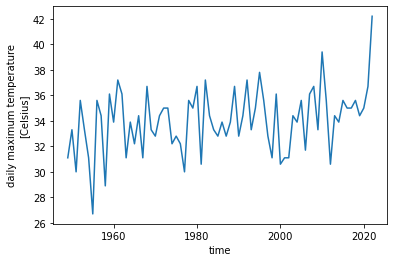

In [4]:
ds_seatac['tasmax'].plot()
plt.show()

In [5]:
cafe_file = '/g/data/xv83/dbi599/tasmax_cafe-c5-d60-pX-f6_19900501-20201101_A-DEC-max_seatac.zarr.zip'

ds_cafe = fileio.open_file(cafe_file)

In [6]:
ds_cafe

<xarray.Dataset>
Dimensions:    (ensemble: 96, init_date: 62, lead_time: 9)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * init_date  (init_date) object 1991-05-01 00:00:00 ... 2021-11-01 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8
    time       (lead_time, init_date) object dask.array<chunksize=(9, 62), meta=np.ndarray>
Data variables:
    tasmax     (init_date, lead_time, ensemble) float32 dask.array<chunksize=(1, 9, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Wed Aug 11 12:56:49 2021: /g/data/e14/dbi599/miniconda3/envs/...
    title:      AccessOcean-AM2

In [7]:
# shape, location (mean), scale (stdev)
gev_shape, gev_loc, gev_scale = gev.fit(ds_cafe['tasmax'].values)
print(gev_shape, gev_loc, gev_scale)

0.2535532351612009 32.036434374768916 3.6349083191114673


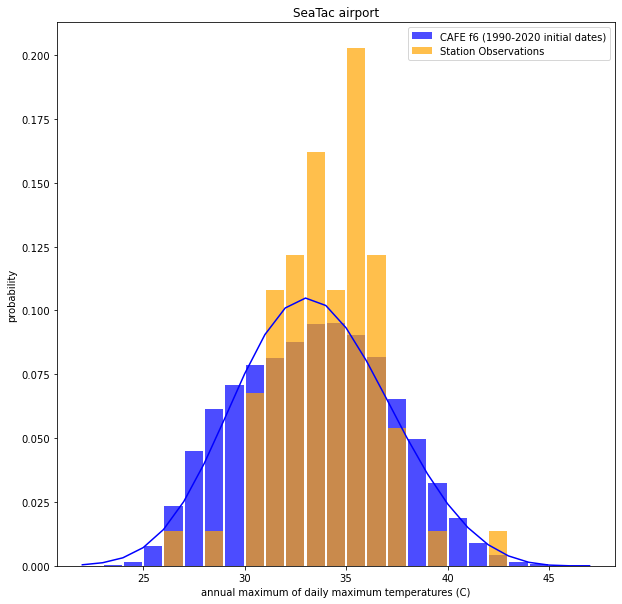

In [8]:
fig = plt.figure(figsize=[10, 10])

ds_cafe['tasmax'].plot.hist(bins=np.arange(23, 46),
                            density=True,
                            rwidth=0.9,
                            alpha=0.7,
                            color='blue',
                            label='CAFE f6 (1990-2020 initial dates)')

xvals = np.arange(22, 48)
gev_pdf = gev.pdf(xvals, gev_shape, gev_loc, gev_scale)
plt.plot(xvals, gev_pdf, color='blue')

ds_seatac['tasmax'].plot.hist(bins=np.arange(23, 46),
                              density=True,
                              rwidth=0.9,
                              alpha=0.7,
                              color='orange',
                              label='Station Observations')

plt.legend()
plt.xlabel('annual maximum of daily maximum temperatures (C)')
plt.ylabel('probability')
plt.title('SeaTac airport')
#plt.savefig(f'/g/data/xv83/dbi599/tasmax_histogram_seatac.png', bbox_inches='tight', facecolor='white')
plt.show()

In [9]:
ds_cafe['tasmax']

<xarray.DataArray 'tasmax' (init_date: 62, lead_time: 9, ensemble: 96)>
dask.array<open_dataset-8dfa069eb89c9788ea2610a174b18d4etasmax, shape=(62, 9, 96), dtype=float32, chunksize=(1, 9, 96), chunktype=numpy.ndarray>
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * init_date  (init_date) object 1991-05-01 00:00:00 ... 2021-11-01 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8
    time       (lead_time, init_date) object dask.array<chunksize=(9, 62), meta=np.ndarray>
Attributes:
    cell_methods:   time: max
    long_name:      temperature at 2 m
    time_avg_info:  average_T1,average_T2,average_DT
    units:          °C
    valid_range:    [100.0, 400.0]

In [10]:
maximum = float(ds_cafe['tasmax'].max().values)
maximum

46.101165771484375

In [11]:
ds_cafe_stacked = ds_cafe.stack({'sample': ['ensemble', 'init_date', 'lead_time']}).compute()

In [12]:
ds_cafe_stacked

<xarray.Dataset>
Dimensions:    (sample: 53568)
Coordinates:
    time       (sample) object 1991-05-01 00:00:00 ... 2029-11-01 00:00:00
  * sample     (sample) MultiIndex
  - ensemble   (sample) int64 1 1 1 1 1 1 1 1 1 1 ... 96 96 96 96 96 96 96 96 96
  - init_date  (sample) object 1991-05-01 00:00:00 ... 2021-11-01 00:00:00
  - lead_time  (sample) int64 0 1 2 3 4 5 6 7 8 0 1 2 ... 7 8 0 1 2 3 4 5 6 7 8
Data variables:
    tasmax     (sample) float32 28.8 36.74 27.87 33.88 ... 33.17 38.9 30.19
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Wed Aug 11 12:56:49 2021: /g/data/e14/dbi599/miniconda3/envs/...
    title:      AccessOcean-AM2

In [21]:
population_size = 62 * 9 * 96
n_repeats = 1000

df_random = pd.DataFrame([maximum]*n_repeats, columns=[population_size])
      
for sample_size in [10, 50, 100, 500, 1000, 5000, 10000]:
    estimates = []
    for resample in range(n_repeats):
        random_indexes = np.random.choice(population_size, size=sample_size, replace=False)
        random_indexes.sort()
        tasmax_max = float(ds_cafe_stacked['tasmax'].isel({'sample': random_indexes}).max().values)
        estimates.append(tasmax_max)
    df_random[sample_size] = estimates

df_random = df_random.reindex(sorted(df_random.columns), axis=1)

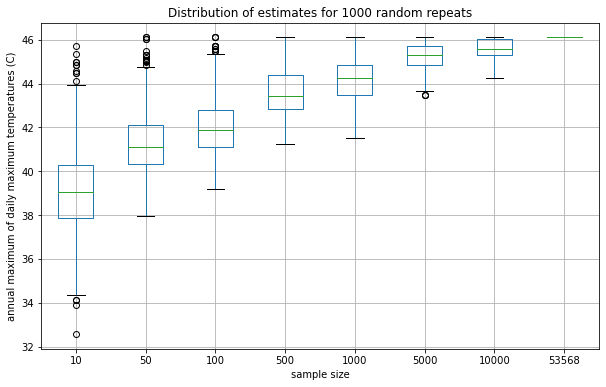

In [22]:
fig = plt.figure(figsize=[10, 6])
df_random.boxplot()
plt.title('Distribution of estimates for 1000 random repeats')
plt.xlabel('sample size')
plt.ylabel('annual maximum of daily maximum temperatures (C)')
plt.show()

The degrees of freedom in my plot reduces as the sample size increases because it's not an infinite sample like the toy example. To check whether that matters much I could fit a GEV to the model data, sample from that, and then overlay the corresponding box and whisker plot on the one above. They look pretty similar...

In [36]:
gev_dict = {}
n_repeats = 1000
for sample_size in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
    estimates = []
    for resample in range(n_repeats):
        tasmax_max = gev.rvs(gev_shape, loc=gev_loc, scale=gev_scale, size=sample_size).max()
        estimates.append(tasmax_max)
    gev_dict[sample_size] = estimates

df_gev = pd.DataFrame(gev_dict)
df_gev = df_gev.reindex(sorted(df_gev.columns), axis=1)

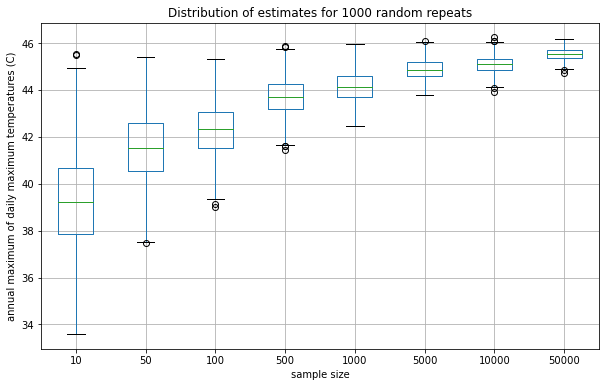

In [39]:
fig = plt.figure(figsize=[10, 6])
df_gev.boxplot()
plt.title('Distribution of estimates for 1000 random repeats')
plt.xlabel('sample size')
plt.ylabel('annual maximum of daily maximum temperatures (C)')
plt.show()

The maximum temperature in the SeaTac obs was 42.2C.

TODO: Plot the likelihood of sampling at least one event > some value for different sample sizes, where some value is 40, 42, 44, etc.

TODO: Plot the return value distributions (return value just number of years over a threshold divided by the numberof samples)

Is there a simple test we could define to determine whether your sample is sufficiently large? (e.g. rainfall)


In [53]:
def likelihood_curve(threshold):
    """Blah"""
    
    population_size = ds_cafe_stacked['tasmax'].size
    n_repeats = 1000
    sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000, population_size]
    likelihoods = []
    for sample_size in sample_sizes:
        event_count = []
        for resample in range(n_repeats):
            random_indexes = np.random.choice(population_size, size=sample_size, replace=False)
            random_indexes.sort()
            tasmax_max = float(ds_cafe_stacked['tasmax'].isel({'sample': random_indexes}).max().values)
            event_count.append(tasmax_max > threshold)
        n_events = np.sum(event_count)
        likelihood = (n_events / n_repeats) * 100
        likelihoods.append(likelihood)
    
    return likelihoods, sample_sizes

<ipython-input-52-da626abe5b49>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + sample_sizes)


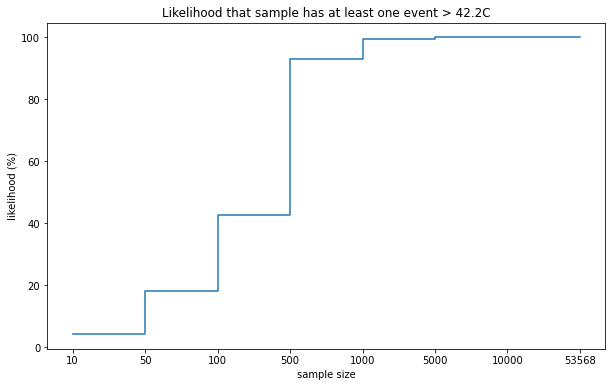

In [52]:
likelihoods, sample_sizes = likelihood_curve(42.2)

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot()

ax.step(np.arange(len(sample_sizes)) + 1, likelihoods, where='post')
ax.set_xticklabels([0] + sample_sizes)
ax.set_ylabel('likelihood (%)')
ax.set_xlabel('sample size')
ax.set_title('Likelihood that sample has at least one event > 42.2C')
plt.show()

<ipython-input-54-370b36fb48d9>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + sample_sizes)


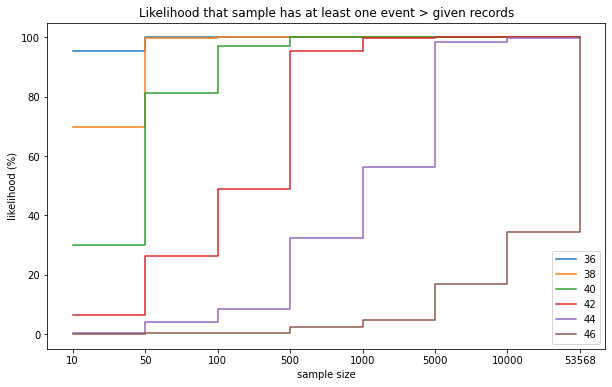

In [54]:
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot()

thresholds = [36, 38, 40, 42, 44, 46]
for threshold in thresholds:
    likelihoods, sample_sizes = likelihood_curve(threshold)
    ax.step(np.arange(len(sample_sizes)) + 1, likelihoods, where='post', label=threshold)
ax.set_xticklabels([0] + sample_sizes)
ax.set_ylabel('likelihood (%)')
ax.set_xlabel('sample size')
ax.set_title('Likelihood that sample has at least one event > given records')
ax.legend()
plt.show()

In [ ]:
population_size = 62 * 9 * 96
n_repeats = 10
perfect_score = 1

df_ks_pvals = pd.DataFrame([perfect_score]*n_repeats, columns=[population_size])
      
for sample_size in [10, 50, 100, 500, 1000, 5000, 10000]:
    pvals = []
    for resample in range(n_repeats):
        random_indexes = np.random.choice(population_size, size=sample_size, replace=False)
        random_indexes.sort()
        sample_ds = ds_cafe_stacked['tasmax'].isel({'sample': random_indexes})
        ks_score, pval = xks.ks1d2s(sample_ds, ds_cafe_stacked['tasmax'], 'sample')
        pvals.append(pval)
        
    df_ks_pvals[sample_size] = pvals

df_ks_pvals = df_ks_pvals.reindex(sorted(df_ks_pvals.columns), axis=1)

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1,

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

In [ ]:
fig = plt.figure(figsize=[10, 6])
df_ks_pvals.boxplot()
plt.title('Distribution for 10 random repeats on annual maximum of daily maximum temperature data')
plt.xlabel('sample size')
plt.ylabel('p-values from KS-test')
plt.show()

In [14]:
xks.ks1d2s(ds_cafe_stacked['tasmax'].isel(sample=slice(0,100)), ds_cafe_stacked['tasmax'].isel(sample=slice(0,100)), 'sample')

/home/599/dbi599/xks/xks.py:60: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_wrap_ks_2samp" failed type inference due to: Untyped global name 'ks_2samp': Cannot determine Numba type of <class 'function'>

File "../../xks/xks.py", line 66:
    # def _wrap_ks_2samp(data1, data2):
        <source elided>
        data2 = data2[~np.isnan(data2)]
        D[:], p[:] = ks_2samp(data1, data2)
        ^

  @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
/g/data/e14/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_wrap_ks_2samp" was compiled in object mode without forceobj=True.

File "../../xks/xks.py", line 61:
    @guvectorize([(float64[:], float64[:], float64[:], float64[:])], '(n), (m) -> (), ()')
    def _wrap_ks_2samp(data1, data2, D, p):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/g/data/e14/dbi599/miniconda3/e

(<xarray.DataArray 'tasmax' ()>
 array(0.),
 <xarray.DataArray 'tasmax' ()>
 array(1.))